In [1]:
import json
from pathlib import Path
from IPython.display import display, HTML
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageFont, ImageDraw
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
pred_file = Path('./traffic_light_2020/yolov5x6_1280_cross_prod_visible_only_imgsize=1280_weights=best.json')
preds = json.loads(pred_file.read_text())
preds['metadata']

{'model': './runs/traffic_light_2020_undistorted/yolov5x6_1280_cross_prod_visible_only/weights/best.pt',
 'names': {'0': 'RED_SOLID_NON_RELEVANT',
  '1': 'RED_SOLID_RELEVANT',
  '2': 'AMBER_SOLID_NON_RELEVANT',
  '3': 'AMBER_SOLID_RELEVANT',
  '4': 'GREEN_SOLID_NON_RELEVANT',
  '5': 'GREEN_SOLID_RELEVANT',
  '6': 'RED_AND_AMBER_NON_RELEVANT',
  '7': 'RED_AND_AMBER_RELEVANT'},
 'image_size': [1280],
 'image_root': '/mnt/remote/data/users/thomasssajot/yolo_dataset/traffic_lights_2020/undistorted/focal_len=650__sensor_size_hw=1200x1920/images'}

In [32]:
predictions = []
i = 0
for k, v in tqdm(preds['predictions'].items(), ncols=130, desc='Load predictions as dataframe', total=len(preds['predictions'])):
    i += 1
    df = pd.DataFrame(v, columns=['x0', 'y0', 'x1', 'y1', 'conf', 'class'])
    df['file'] = k
    predictions.append(df)
predictions = pd.concat(predictions).reset_index(drop=True)
predictions['name'] = predictions['class'].astype(int).astype(str).map(preds['metadata']['names'].get)

Load predictions as dataframe: 100%|██████████████████████████████████████████████████████| 22206/22206 [00:12<00:00, 1708.73it/s]


In [40]:
{k: v for k, v in  preds['metadata']['names'].items() if not v.endswith('NON_RELEVANT') and 'NONE' not in v and 'UNKNOWN' not in v}

{'1': 'RED_SOLID_RELEVANT',
 '3': 'AMBER_SOLID_RELEVANT',
 '5': 'GREEN_SOLID_RELEVANT',
 '7': 'RED_AND_AMBER_RELEVANT'}

In [41]:
d = {
        "/home/thomassajot/dataset/traffic_lights_entron_classification_v2/focal_len=650__sensor_size_hw=1200x1920/AMBER_SOLID/brizo/2022-08-12--08-02-47--session_2022_06_09_12_49_14_aml-v100-2nn-2_tomnewton_full_databricks_data_pipeline/1660291793099382unixus.jpeg": [],
        "/home/thomassajot/dataset/traffic_lights_entron_classification_v2/focal_len=650__sensor_size_hw=1200x1920/AMBER_SOLID/brizo/2022-08-12--08-02-47--session_2022_06_09_12_49_14_aml-v100-2nn-2_tomnewton_full_databricks_data_pipeline/1660291793901201unixus.jpeg": [
            [
                0.4794558584690094,
                0.43964463472366333,
                0.48419007658958435,
                0.45557597279548645,
                0.6985494494438171,
                3.0
            ],
            [
                0.408389151096344,
                0.43382400274276733,
                0.4136212170124054,
                0.4532793164253235,
                0.5960707068443298,
                3.0
            ]
        ],}

In [43]:
pd.DataFrame.from_dict(d, orient='index')

,0,1
/home/thomassajot/dataset/traffic_lights_entron_classification_v2/focal_len=650__sensor_size_hw=1200x1920/AMBER_SOLID/brizo/2022-08-12--08-02-47--session_2022_06_09_12_49_14_aml-v100-2nn-2_tomnewton_full_databricks_data_pipeline/1660291793099382unixus.jpeg,None,None
/home/thomassajot/dataset/traffic_lights_entron_classification_v2/focal_len=650__sensor_size_hw=1200x1920/AMBER_SOLID/brizo/2022-08-12--08-02-47--session_2022_06_09_12_49_14_aml-v100-2nn-2_tomnewton_full_databricks_data_pipeline/1660291793901201unixus.jpeg,"[0.4794558584690094, 0.43964463472366333, 0.48...","[0.408389151096344, 0.43382400274276733, 0.413..."


In [33]:

def extract_traffic_light_colour_from_cross_product(df: pd.DataFrame) -> dict:
    """
    Given the most relevant prediction, get the largest overlapping traffic light bounding box with a colour
    Return the colour or 'NONE'
    """
    mask = df['class'].isin([1, 3, 5])
    if  len(df) == 0 or not mask.any():
        traffic_light_colour = 'NONE'
        traffic_light_conf = 0
    else:
        most_relevant_idx = df[mask]['conf'].idxmax()
        traffic_light_colour, traffic_light_conf = df.loc[most_relevant_idx][['name', 'conf']]
        traffic_light_colour = traffic_light_colour.replace('_RELEVANT', '')
    return dict(colour=traffic_light_colour, conf=traffic_light_conf)

def _draw_bbox_with_text(draw, xy, text: str, size: int, colour: str = 'red'):
    fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", size)
    bbox = draw.textbbox(xy, text, font=fnt, anchor='ls')
    draw.rectangle(bbox, fill="red")
    draw.text(xy, text, font=fnt, fill="black", anchor='ls')
    draw.rectangle(xy, outline='red', width=2)
        
def draw_annotations(image, annotations, size: int = 30):
    width, height = image.size
    annotations[['x0', 'y0', 'x1', 'y1']] = annotations[['x0', 'y0', 'x1', 'y1']].astype(float)
    annotations['x0'] *= width
    annotations['x1'] *= width
    annotations['y0'] *= height
    annotations['y1'] *= height
    annotations[['x0', 'y0', 'x1', 'y1']] = annotations[['x0', 'y0', 'x1', 'y1']].astype(int)
    
    draw = ImageDraw.Draw(image)
    for _, (label, conf, *xy) in annotations[['name', 'conf', 'x0', 'y0', 'x1', 'y1']].iterrows():
        handle = "".join([x[0] for x in label.split("_")])
        text = f'{handle}:{conf*100:.0f}'
        _draw_bbox_with_text(draw, xy, text, size)
    

def display(file: str, preds: pd.DataFrame, size: int = 30):
    assert len({'x0', 'y0', 'x1', 'y1', 'conf', 'class', 'name', 'file'} - set(preds.columns)) == 0
    image = Image.open(file)
    annotations = preds.query(f'file == "{file}"').copy(True)
    print(annotations)
    pred = extract_traffic_light_colour_from_cross_product(annotations.copy(deep=True))
    print('Prediction:', pred)
    draw_annotations(image, annotations, size=size)
    image = image.crop(box=(100, 300, 1820, 800))
    return image
    
    

In [34]:
files = predictions['file'].unique()

In [35]:
i = 0

         x0        y0        x1        y1      conf  class  \
4  0.650870  0.382158  0.666812  0.429197  0.915363    1.0   
5  0.172786  0.371269  0.206367  0.442333  0.891658    0.0   
6  0.584690  0.417059  0.594973  0.448191  0.887063    1.0   
7  0.294914  0.421634  0.307146  0.459361  0.462445    0.0   

                                                file                    name  
4  /mnt/remote/data/users/thomasssajot/yolo_datas...      RED_SOLID_RELEVANT  
5  /mnt/remote/data/users/thomasssajot/yolo_datas...  RED_SOLID_NON_RELEVANT  
6  /mnt/remote/data/users/thomasssajot/yolo_datas...      RED_SOLID_RELEVANT  
7  /mnt/remote/data/users/thomasssajot/yolo_datas...  RED_SOLID_NON_RELEVANT  
Prediction: {'colour': 'RED_SOLID', 'conf': 0.9153634309768677}


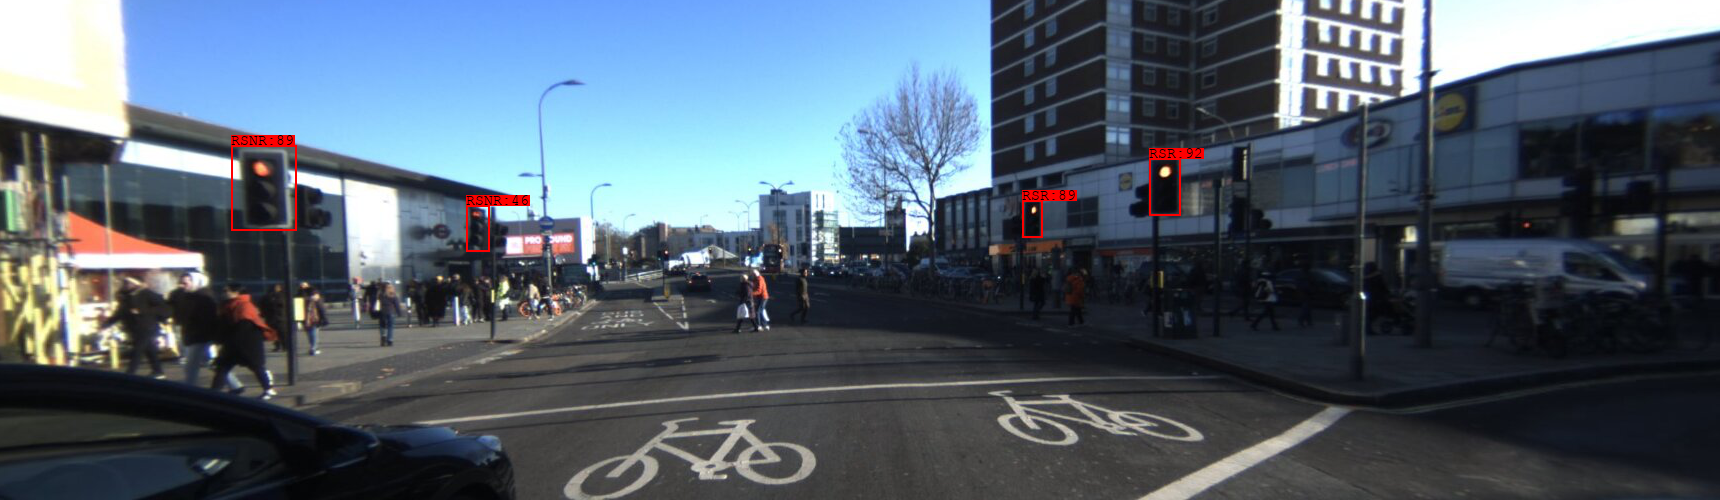

In [36]:
i += 1
display(files[i], predictions, size=15)